# Chapter 5. Entity-level sentiment analysis
This notebook is complementary material to Chapter #. of the thesis.

# Sentiment and Adjusted Close Price
- In this notebook we use sentiment data (only date and sentiment after deleting acrticles metadata) from (ETL) transform phase and the Guardian as source.
- Price data is taken from yahoo finance.

## Get sentiment and price data

In [24]:
%pip install -q -r requirements.txt


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:
import os
import json
import pandas as pd

SECTIONS = ["business", "technology"]
TICKER = "NVDA"  # NVDA, TSLA, MSFT, AAPL, AMZN, GOOGL, META
START = "2024-01-01"
END = "2024-03-31"


def create_dataframe() -> pd.DataFrame:
    """
    Creates a DataFrame from sentiment data related to a specific ticker.

    This function iterates through JSON files located in specified sections (e.g., "business", "technology"),
    extracting sentiment data related to a predefined ticker. It filters and aggregates this data into a pandas DataFrame,
    focusing on the sentiment classification and values of positive, neutral, and negative sentiments, along with the publication date.

    Returns:
        pd.DataFrame: A DataFrame containing the filtered sentiment data with columns for the date, sentiment classification,
        and counts of positive, neutral, and negative sentiments.
    """
    data = []
    for section in SECTIONS:
        section_path = f"data/transform/{section}"
        for file_name in os.listdir(section_path):
            file_path = os.path.join(section_path, file_name)
            with open(file_path, "r") as file:
                json_data = json.load(file)
                data.extend(json_data)

    filtered_data = []

    for item in data:
        for ticker_info in item["tickers"]:
            if ticker_info["ticker"] == TICKER:
                if item["published_date"] > START and item["published_date"] < END:
                    record = {
                        "date": item["published_date"],
                        "classification": ticker_info["sentiment"]["classification"],
                        "positive": ticker_info["sentiment"]["positive"],
                        "neutral": ticker_info["sentiment"]["neutral"],
                        "negative": ticker_info["sentiment"]["negative"],
                    }
                    filtered_data.append(record)
                    break

    df = pd.DataFrame(filtered_data)
    df["date"] = pd.to_datetime(df["date"]).dt.date
    return df


sentiment_df = create_dataframe()

display(sentiment_df["classification"].value_counts())
display(sentiment_df.head())

classification
POSITIVE    11
NEUTRAL      9
Name: count, dtype: int64

,date,classification,positive,neutral,negative
0,2024-02-08,NEUTRAL,0.08627,0.90557,0.00815
1,2024-01-26,NEUTRAL,0.31067,0.60203,0.08730
2,2024-03-05,POSITIVE,0.91883,0.05845,0.02272
3,2024-03-01,POSITIVE,0.99787,0.00109,0.00104
4,2024-02-26,POSITIVE,0.89401,0.05474,0.05125


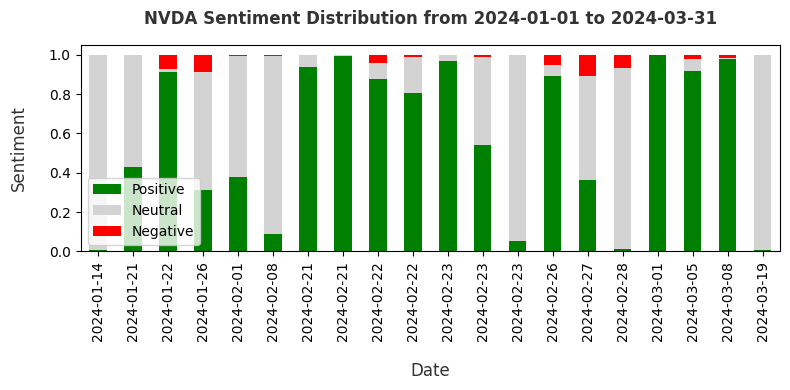

In [26]:
# Pre-aggreated articles

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Convert 'date' column to datetime format without time
sentiment_df["date"] = pd.to_datetime(sentiment_df["date"], format="%Y-%m-%d").dt.date

# Sort the DataFrame by the 'date' column
sentiment_df = sentiment_df.sort_values(by="date")

# Now that 'date' is confirmed to be in datetime format and sorted, proceed with the plotting
ax = sentiment_df.set_index("date")[["positive", "neutral", "negative"]].plot(
    kind="bar", stacked=True, color=["green", "lightgray", "red"], figsize=(8, 4)
)

plt.xticks(rotation=90)

ax.set_title(
    f"{TICKER} Sentiment Distribution from {START} to {END}",
    pad=15,
    color="#333333",
    weight="bold",
)
ax.set_xlabel("Date", labelpad=15, color="#333333", fontsize="large")
ax.set_ylabel("Sentiment", labelpad=15, color="#333333", fontsize="large")

ax.legend(loc="lower left")
plt.legend(
    [Patch(facecolor="green"), Patch(facecolor="lightgray"), Patch(facecolor="red")],
    ["Positive", "Neutral", "Negative"],
    loc="lower left",
)

plt.tight_layout()
plt.show()

In [27]:
import yfinance as yf

try:
    # Fetch price data from Yahoo Finance
    price_data = yf.download({TICKER}, start=START, end=END)
    price_data = price_data[["Adj Close"]]
except Exception as e:
    print(f"Failed download: {e}")

[*********************100%%**********************]  1 of 1 completed


In [28]:
# For the case of "may be delisted error" https://stackoverflow.com/questions/71729671/python-yfinance-failed-downloads-no-data-found-symbol-may-be-delisted you already have to install the latest version of yfinance
# %pip uninstall -y yfinance
# %pip install yfinance

- It's necessary to align the dates in sentiment_df with the closest trading day.

In [29]:
import pandas as pd

# Assuming sentiment_df and price_data are already defined

# Sort dataframes by date
sentiment_df = sentiment_df.sort_values("date")
price_data = price_data.sort_index()

# Get the market days from price_data index
market_days = price_data.index


def find_nearest_market_day(
    date: pd.Timestamp, market_days: pd.DatetimeIndex
) -> pd.Timestamp:
    """
    Finds the nearest market day to a given date.

    This function checks if the given date is a market day. If it is, the date is returned.
    If not, it finds the nearest market day, considering both past and future market days,
    and returns the closest one. If the given date is equally distant
    from a past and a future market day, the future market day is preferred.

    Parameters:
        date (pd.Timestamp): The date for which to find the nearest market day.
        market_days (pd.DatetimeIndex): An index of market days to search within.

    Returns:
        pd.Timestamp: The nearest market day to the given date.
    """
    if date in market_days:
        return date
    else:
        # Find the nearest future market day
        future_day = market_days[market_days >= date].min()
        # Find the nearest past market day
        past_day = market_days[market_days <= date].max()
        # Return the closest of the two
        if pd.isna(future_day):
            return past_day
        if pd.isna(past_day):
            return future_day
        if (future_day - date) < (date - past_day):
            return future_day
        else:
            return past_day


# Ensure 'date' column in sentiment_df is in datetime format
sentiment_df["date"] = pd.to_datetime(sentiment_df["date"])

# Find nearest market day for each date in sentiment_df
sentiment_df["date"] = sentiment_df["date"].apply(
    lambda x: find_nearest_market_day(x, market_days)
)

# Display value counts for the 'classification' column
print(sentiment_df["classification"].value_counts())

classification
POSITIVE    11
NEUTRAL      9
Name: count, dtype: int64


In [30]:
# save the sentiment_df to a csv file as checkpoint if it is needed
# sentiment_df.to_csv("sentiment_df.csv", index=False)

In [31]:
print(sentiment_df["classification"].value_counts())

classification
POSITIVE    11
NEUTRAL      9
Name: count, dtype: int64


- To ensure accuracy in our analysis, it's essential to aggregate sentiment data entries that occur on the same day into a single record.

In [32]:
import numpy as np

display(
    "Sentiments with same day",
    sentiment_df[sentiment_df["date"].duplicated(keep=False)]
    .sort_values("date")
    .head(),
)


def aggregate_sentiments(group: pd.DataFrame) -> pd.Series:
    """
    Aggregates sentiment data for entries with the same date.

    This function calculates the average sentiment scores (positive, negative, and neutral) for all entries within the same date.
    It then determines the predominant sentiment classification based on the highest average score among the three.
    The aggregated data is returned as a pandas Series containing the predominant classification and the average sentiment scores.

    Parameters:
        group (pd.DataFrame): A DataFrame group containing all entries for a specific date.

    Returns:
        pd.Series: A Series containing the aggregated sentiment data, including the predominant classification and average scores.
    """
    # Calculate the average for positive, negative, and neutral
    avg_positive = group["positive"].mean()
    avg_negative = group["negative"].mean()
    avg_neutral = group["neutral"].mean()

    # Create a dictionary of the averages
    averages = {
        "POSITIVE": avg_positive,
        "NEGATIVE": avg_negative,
        "NEUTRAL": avg_neutral,
    }

    # Find the classification with the highest average value
    highest_avg_classification = max(averages, key=averages.get)

    # Return a Series with the classification and its average value, along with all averages
    return pd.Series(
        {
            "classification": highest_avg_classification,
            "positive": avg_positive,
            "neutral": avg_neutral,
            "negative": avg_negative,
        }
    )


# Aggregate sentiment for each day (we can have multiple sentiments for each day)
sentiment_df = sentiment_df.groupby("date").apply(aggregate_sentiments).reset_index()

display("Aggregated sentiments", sentiment_df["classification"].value_counts())

# Create a signal column based on sentiment
sentiment_df["signal"] = np.where(
    sentiment_df["classification"] == "POSITIVE",
    1,
    np.where(sentiment_df["classification"] == "NEGATIVE", -1, 0),
)
sentiment_df["signal"] = sentiment_df["signal"]

display(sentiment_df["signal"].value_counts())
display(sentiment_df.head())

'Sentiments with same day'

,date,classification,positive,neutral,negative
12,2024-01-22,NEUTRAL,0.42773,0.57054,0.00173
11,2024-01-22,POSITIVE,0.90952,0.01635,0.07414
8,2024-02-21,POSITIVE,0.93554,0.06065,0.00380
19,2024-02-21,POSITIVE,0.99231,0.00712,0.00057
7,2024-02-22,POSITIVE,0.80611,0.18347,0.01043


'Aggregated sentiments'

classification
POSITIVE    8
NEUTRAL     7
Name: count, dtype: int64

signal
1    8
0    7
Name: count, dtype: int64

,date,classification,positive,neutral,negative,signal
0,2024-01-12,NEUTRAL,0.007100,0.988890,0.004010,0
1,2024-01-22,POSITIVE,0.668625,0.293445,0.037935,1
2,2024-01-26,NEUTRAL,0.310670,0.602030,0.087300,0
3,2024-02-01,NEUTRAL,0.380130,0.614300,0.005580,0
4,2024-02-08,NEUTRAL,0.086270,0.905570,0.008150,0


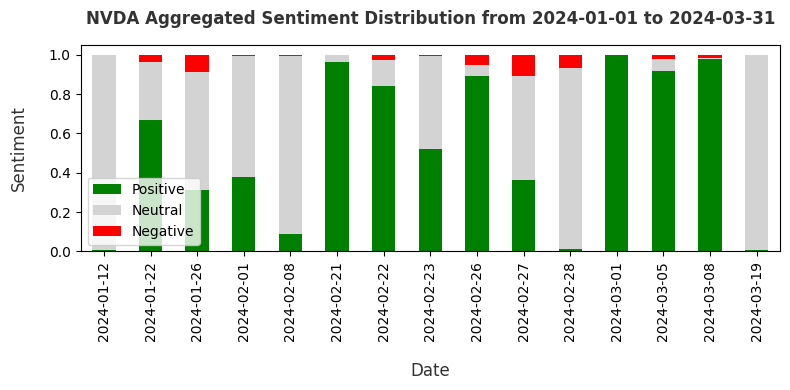

In [33]:
# Aggregated articles

ax = sentiment_df.set_index("date")[["positive", "neutral", "negative"]].plot(
    kind="bar", stacked=True, color=["green", "lightgray", "red"], figsize=(8, 4)
)

ax.xaxis.set_major_formatter(
    plt.FixedFormatter(sentiment_df["date"].dt.strftime("%Y-%m-%d").values)
)

plt.xticks(rotation=90)

ax.set_title(
    f"{TICKER} Aggregated Sentiment Distribution from {START} to {END}",
    pad=15,
    color="#333333",
    weight="bold",
)
ax.set_xlabel("Date", labelpad=15, color="#333333", fontsize="large")
ax.set_ylabel("Sentiment", labelpad=15, color="#333333", fontsize="large")

ax.legend(loc="lower left")
plt.legend(
    [Patch(facecolor="green"), Patch(facecolor="lightgray"), Patch(facecolor="red")],
    ["Positive", "Neutral", "Negative"],
    loc="lower left",
)

plt.tight_layout()
plt.show()

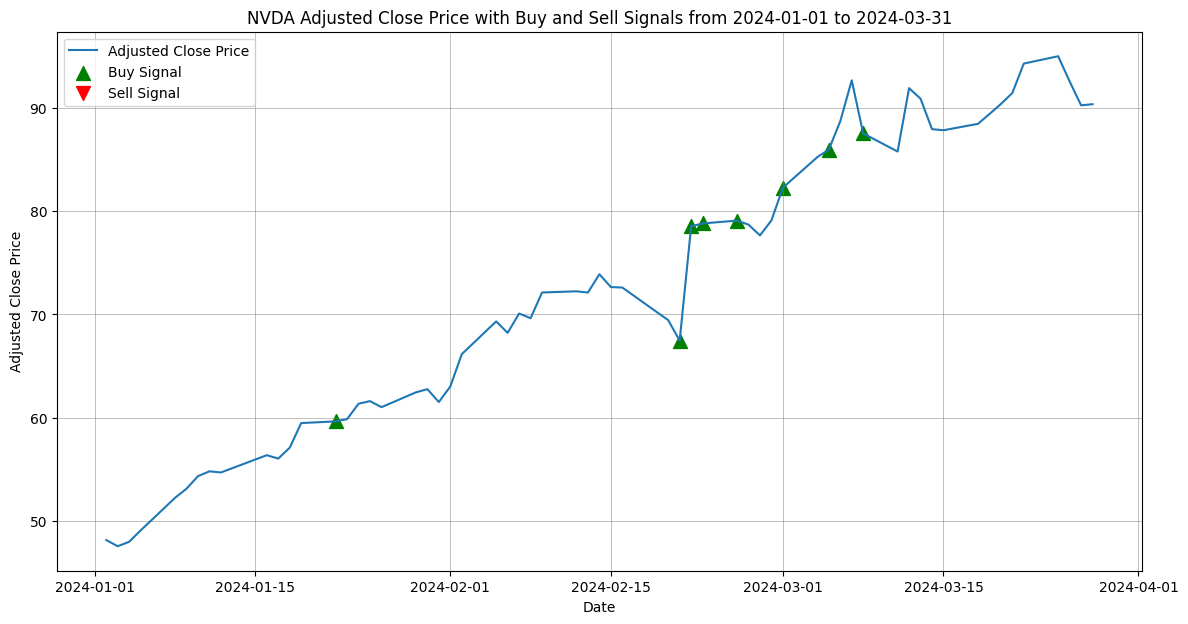

In [34]:
# Merge price data with sentiment data based on the date.
data = price_data.join(sentiment_df.set_index("date"))

# Identify trading days with buy and sell signals based on sentiment analysis.
buy_signals = data[data["signal"] == 1].index
sell_signals = data[data["signal"] == -1].index

# Visualize the adjusted close price along with buy and sell signals on a plot.
plt.figure(figsize=(14, 7))
plt.plot(data["Adj Close"], label="Adjusted Close Price")

# Highlight buy signals with green upward-pointing triangles.
plt.scatter(
    buy_signals,
    data.loc[buy_signals]["Adj Close"],
    marker="^",
    color="g",
    label="Buy Signal",
    s=100,
)

# Highlight sell signals with red downward-pointing triangles.
plt.scatter(
    sell_signals,
    data.loc[sell_signals]["Adj Close"],
    marker="v",
    color="r",
    label="Sell Signal",
    s=100,
)

plt.title(
    f"{TICKER} Adjusted Close Price with Buy and Sell Signals from {START} to {END}"
)
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.grid(color="gray", linestyle="-", linewidth=0.5, alpha=0.7)
plt.show()

- Project neutral sentiment records.
- It's unfortunate that we don't have a sentiment score for all days, as they could provide valuable insights.

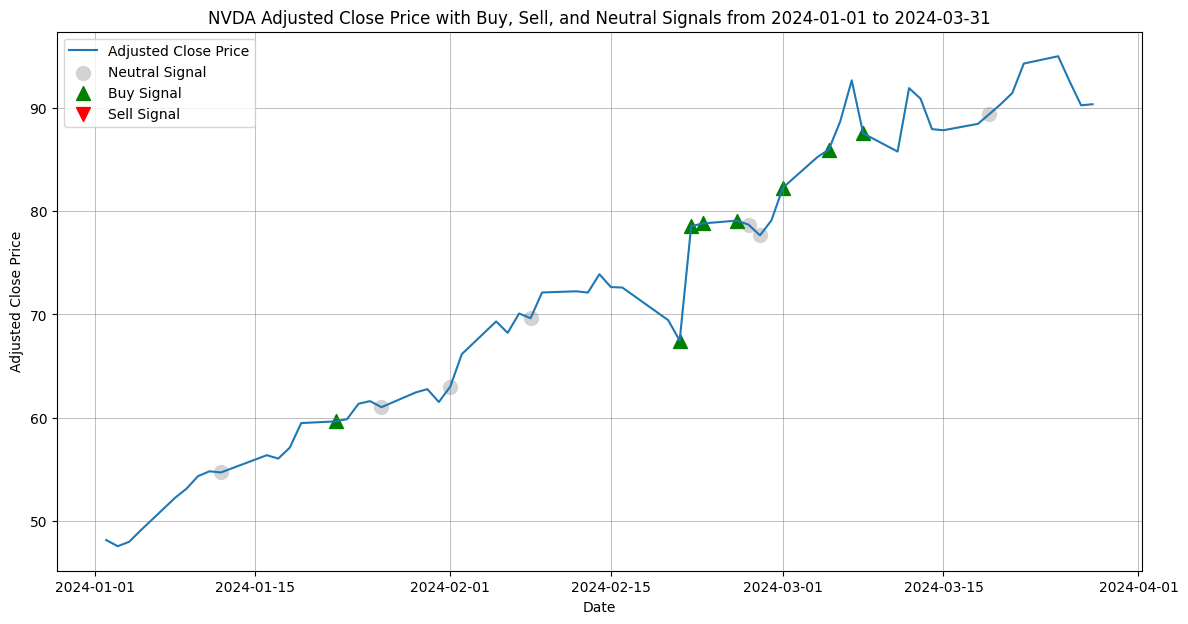

In [35]:
# Identify dates with neutral sentiment classification.
neutral_signals = data[data["classification"] == "NEUTRAL"].index

# Initialize the plot with a specific figure size.
plt.figure(figsize=(14, 7))

# Plot the adjusted close price of the market data.
plt.plot(data["Adj Close"], label="Adjusted Close Price")

# Plot neutral sentiment signals as gray circles.
plt.scatter(
    neutral_signals,
    data.loc[neutral_signals]["Adj Close"],
    marker="o",
    color="lightgray",
    label="Neutral Signal",
    s=100,
)

# Plot buy sentiment signals as green upward-pointing triangles.
plt.scatter(
    buy_signals,
    data.loc[buy_signals]["Adj Close"],
    marker="^",
    color="g",
    label="Buy Signal",
    s=100,
)

# Plot sell sentiment signals as red downward-pointing triangles.
plt.scatter(
    sell_signals,
    data.loc[sell_signals]["Adj Close"],
    marker="v",
    color="r",
    label="Sell Signal",
    s=100,
)

plt.title(
    f"{TICKER} Adjusted Close Price with Buy, Sell, and Neutral Signals from {START} to {END}"
)
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.grid(color="gray", linestyle="-", linewidth=0.5, alpha=0.7)

plt.show()

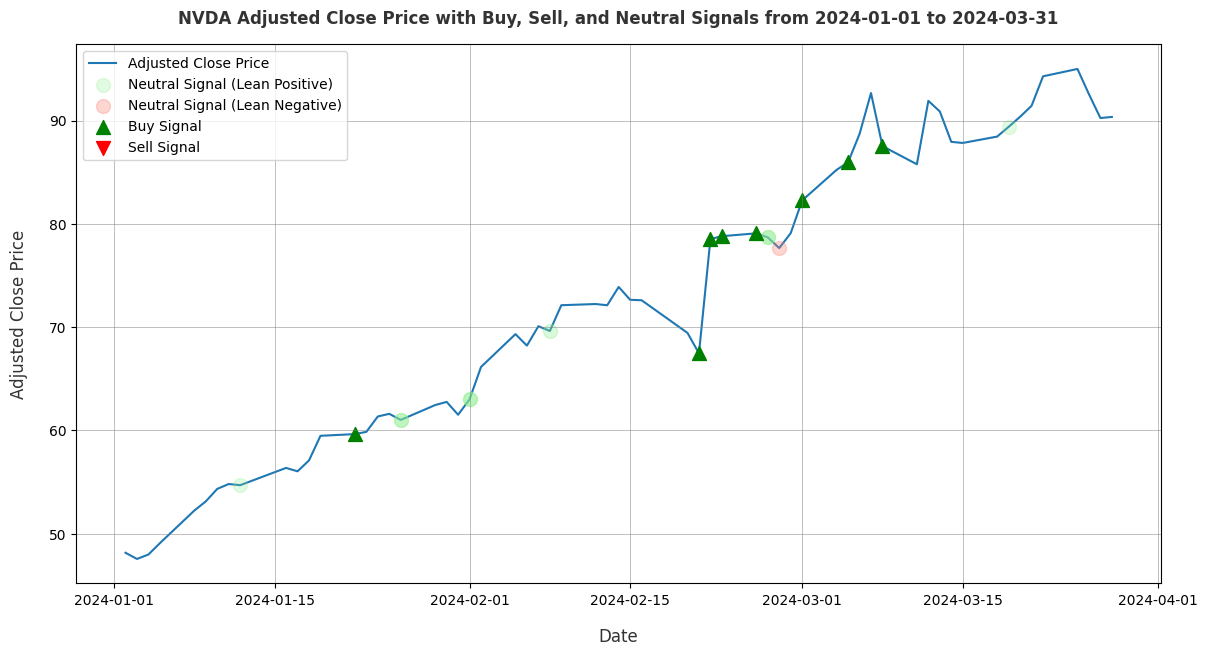

In [36]:
# Initialize the plot with a specific figure size.
plt.figure(figsize=(14, 7))

# Plot the adjusted close price of the market data.
plt.plot(data["Adj Close"], label="Adjusted Close Price", zorder=1)

# Initialize flags to add label only for the first neutral signal of each type
first_neutral_red = True
first_neutral_green = True

# Determine and plot neutral signals with dynamic colors and visibility
for neutral_signal in neutral_signals:
    row = data.loc[neutral_signal]
    if row["positive"] > row["negative"]:
        color = "lightgreen"
        alpha = row["positive"] + 0.25
        # Add label only for the first green neutral signal
        if first_neutral_green:
            plt.scatter(
                neutral_signal,
                row["Adj Close"],
                marker="o",
                color=color,
                alpha=alpha,
                label="Neutral Signal (Lean Positive)",
                s=100,
            )
            first_neutral_green = False
        else:
            plt.scatter(
                neutral_signal,
                row["Adj Close"],
                marker="o",
                color=color,
                alpha=alpha,
                s=100,
            )
    else:
        color = "salmon"
        alpha = row["negative"] + 0.25
        # Add label only for the first red neutral signal
        if first_neutral_red:
            plt.scatter(
                neutral_signal,
                row["Adj Close"],
                marker="o",
                color=color,
                alpha=alpha,
                label="Neutral Signal (Lean Negative)",
                s=100,
            )
            first_neutral_red = False
        else:
            plt.scatter(
                neutral_signal,
                row["Adj Close"],
                marker="o",
                color=color,
                alpha=alpha,
                s=100,
            )

# Plot buy and sell signals
plt.scatter(
    buy_signals,
    data.loc[buy_signals]["Adj Close"],
    marker="^",
    color="g",
    label="Buy Signal",
    s=100,
)
plt.scatter(
    sell_signals,
    data.loc[sell_signals]["Adj Close"],
    marker="v",
    color="r",
    label="Sell Signal",
    s=100,
)

# To avoid duplicate labels in the legend, handle neutral signal legend separately
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Removes duplicate labels
plt.legend(by_label.values(), by_label.keys())

plt.title(
    f"{TICKER} Adjusted Close Price with Buy, Sell, and Neutral Signals from {START} to {END}",
    pad=15,
    color="#333333",
    weight="bold",
)
plt.xlabel("Date", labelpad=15, color="#333333", fontsize="large")
plt.ylabel("Adjusted Close Price", labelpad=15, color="#333333", fontsize="large")
plt.grid(color="gray", linestyle="-", linewidth=0.5, alpha=0.7)
plt.show()

## Backtest with simple hold strategy
- We will backtest a simple hold strategy using the sentiment data.
- Each `POSITIVE` or `NEGATIVE` signal from previous day indicate whether to long or short the stock. 
- We will hold the stock for 7 days and then exit the position.

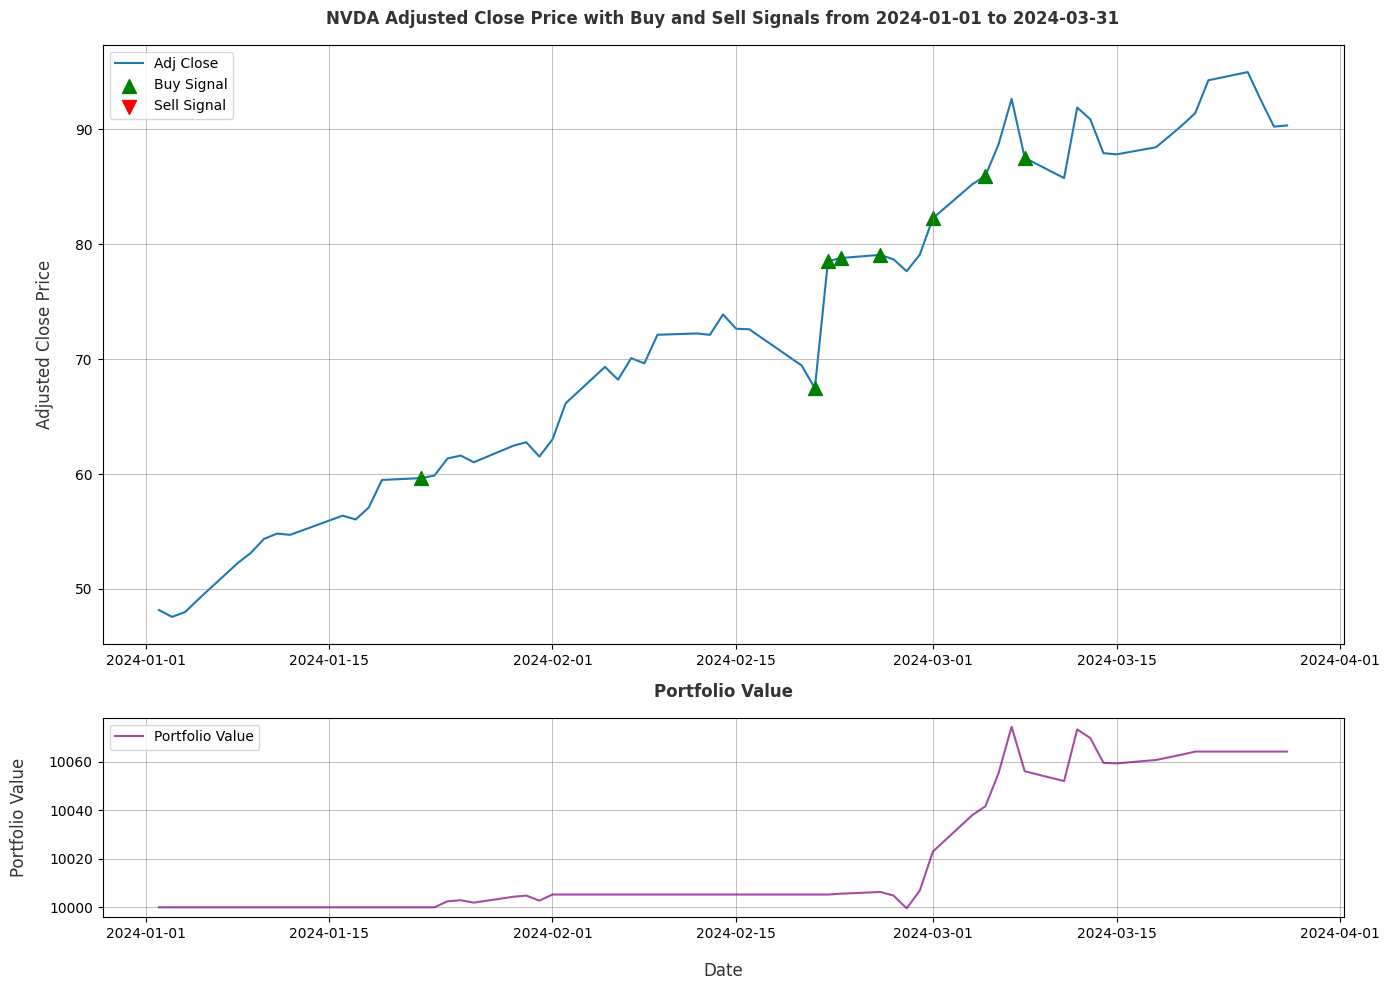

Total Return: 0.64%
Total Long Positions: 8
Total Short Positions: 0


In [37]:
initial_capital = 10000
capital = initial_capital
positions = []  # List to hold all active positions
fixed_buy_amount = 100  # Fixed dollar amount for each buy/sell
holding_period = 7  # Days to hold
portfolio_values = [initial_capital]

long_positions_count = 0
short_positions_count = 0

for i in range(1, len(data["Adj Close"])):
    # Check for buy signals
    if data["signal"][i - 1] == 1 and capital >= fixed_buy_amount:
        buy_price = data["Adj Close"][i]
        shares_to_buy = fixed_buy_amount / buy_price

        # Open new long position
        new_position = {
            "type": "long",
            "entry_price": buy_price,
            "shares_held": shares_to_buy,
            "days_held": holding_period,
        }
        positions.append(new_position)
        capital -= fixed_buy_amount
        long_positions_count += 1

    # Check for sell signals
    if data["signal"][i - 1] == -1 and capital >= fixed_buy_amount:
        sell_price = data["Adj Close"][i]
        shares_to_sell = fixed_buy_amount / sell_price

        # Open new short position
        new_position = {
            "type": "short",
            "entry_price": sell_price,
            "shares_shorted": shares_to_sell,
            "days_held": holding_period,
        }
        positions.append(new_position)
        capital += fixed_buy_amount
        short_positions_count += 1

    # Manage all open positions
    for position in positions:
        if position["type"] == "long":
            # Exit long position after holding period
            if position["days_held"] <= 0:
                sell_price = data["Adj Close"][i]
                sell_amount = position["shares_held"] * sell_price
                capital += sell_amount
                positions.remove(position)
            else:
                position["days_held"] -= 1

        elif position["type"] == "short":
            # Cover short position after holding period
            if position["days_held"] <= 0:
                buy_price = data["Adj Close"][i]
                buy_back_amount = position["shares_shorted"] * buy_price
                capital -= buy_back_amount
                positions.remove(position)
            else:
                position["days_held"] -= 1

    # Calculate portfolio value considering all open positions
    portfolio_value = capital
    for position in positions:
        if position["type"] == "long":
            portfolio_value += position["shares_held"] * data["Adj Close"][i]
        elif position["type"] == "short":
            portfolio_value -= position["shares_shorted"] * data["Adj Close"][i]
    portfolio_values.append(portfolio_value)

# Calculate performance metrics
total_return = (portfolio_values[-1] - initial_capital) / initial_capital

# Add portfolio values to the data DataFrame
data["Portfolio Value"] = portfolio_values

# Create subplots (plotting code remains the same)
fig, ax1 = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={"height_ratios": [3, 1]})

# Plot Adjusted Close and signals on the first subplot
ax1[0].plot(data["Adj Close"], label="Adj Close", zorder=1)
ax1[0].scatter(
    buy_signals,
    data.loc[buy_signals]["Adj Close"],
    marker="^",
    color="g",
    label="Buy Signal",
    s=100,
)
ax1[0].scatter(
    sell_signals,
    data.loc[sell_signals]["Adj Close"],
    marker="v",
    color="r",
    label="Sell Signal",
    s=100,
)
ax1[0].set_title(
    f"{TICKER} Adjusted Close Price with Buy and Sell Signals from {START} to {END}",
    pad=15,
    color="#333333",
    weight="bold",
)
ax1[0].legend()
ax1[0].set_ylabel(
    "Adjusted Close Price", labelpad=15, color="#333333", fontsize="large"
)
ax1[0].grid(color="gray", linestyle="-", linewidth=0.5, alpha=0.7)

# Plot Portfolio Value on the second subplot
ax1[1].plot(
    data.index,
    data["Portfolio Value"],
    label="Portfolio Value",
    color="purple",
    alpha=0.7,
)
ax1[1].set_title("Portfolio Value", pad=15, color="#333333", weight="bold")
ax1[1].set_xlabel("Date", labelpad=15, color="#333333", fontsize="large")
ax1[1].set_ylabel("Portfolio Value", labelpad=15, color="#333333", fontsize="large")
ax1[1].legend(loc="upper left")
ax1[1].grid(color="gray", linestyle="-", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

print(f"Total Return: {total_return*100:.2f}%")
print(f"Total Long Positions: {long_positions_count}")
print(f"Total Short Positions: {short_positions_count}")

Total results:
- NVDA 0.64%
- TSLA 0.18%
- MSFT -0.03%
- AAPL 0.00%
- AMZN -0.12%
- GOOGL 0.04%
- META 0.03%
- sum = 0.74%

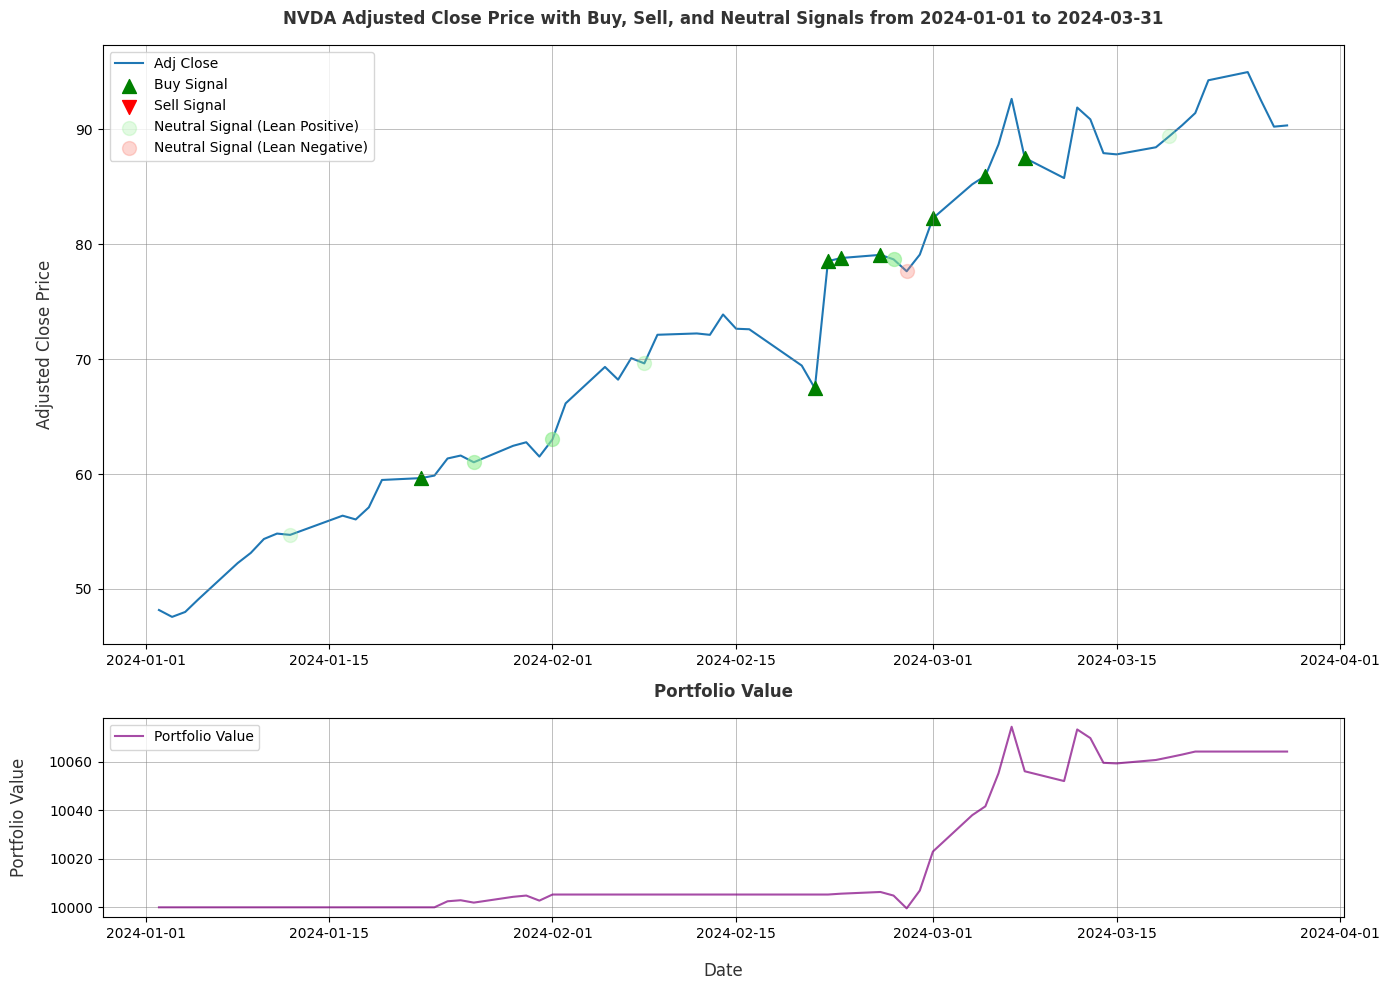

Total Return: 0.64%
Total Long Positions: 8
Total Short Positions: 0


In [38]:
# Merge neutral and strategy signals (repetitive code) to display both on the same plot

initial_capital = 10000
capital = initial_capital
positions = []  # List to hold all active positions
fixed_buy_amount = 100  # Fixed dollar amount for each buy/sell
holding_period = 7  # Days to hold
portfolio_values = [initial_capital]

long_positions_count = 0
short_positions_count = 0

for i in range(1, len(data["Adj Close"])):
    # Check for buy signals
    if data["signal"][i - 1] == 1 and capital >= fixed_buy_amount:
        buy_price = data["Adj Close"][i]
        shares_to_buy = fixed_buy_amount / buy_price

        # Open new long position
        new_position = {
            "type": "long",
            "entry_price": buy_price,
            "shares_held": shares_to_buy,
            "days_held": holding_period,
        }
        positions.append(new_position)
        capital -= fixed_buy_amount
        long_positions_count += 1

    # Check for sell signals
    if data["signal"][i - 1] == -1 and capital >= fixed_buy_amount:
        sell_price = data["Adj Close"][i]
        shares_to_sell = fixed_buy_amount / sell_price

        # Open new short position
        new_position = {
            "type": "short",
            "entry_price": sell_price,
            "shares_shorted": shares_to_sell,
            "days_held": holding_period,
        }
        positions.append(new_position)
        capital += fixed_buy_amount
        short_positions_count += 1

    # Manage all open positions
    for position in positions:
        if position["type"] == "long":
            # Exit long position after holding period
            if position["days_held"] <= 0:
                sell_price = data["Adj Close"][i]
                sell_amount = position["shares_held"] * sell_price
                capital += sell_amount
                positions.remove(position)
            else:
                position["days_held"] -= 1

        elif position["type"] == "short":
            # Cover short position after holding period
            if position["days_held"] <= 0:
                buy_price = data["Adj Close"][i]
                buy_back_amount = position["shares_shorted"] * buy_price
                capital -= buy_back_amount
                positions.remove(position)
            else:
                position["days_held"] -= 1

    # Calculate portfolio value considering all open positions
    portfolio_value = capital
    for position in positions:
        if position["type"] == "long":
            portfolio_value += position["shares_held"] * data["Adj Close"][i]
        elif position["type"] == "short":
            portfolio_value -= position["shares_shorted"] * data["Adj Close"][i]
    portfolio_values.append(portfolio_value)

# Calculate performance metrics
total_return = (portfolio_values[-1] - initial_capital) / initial_capital

# Add portfolio values to the data DataFrame
data["Portfolio Value"] = portfolio_values

# Create subplots (plotting code)
fig, ax1 = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={"height_ratios": [3, 1]})

# Plot Adjusted Close and signals on the first subplot
ax1[0].plot(data["Adj Close"], label="Adj Close", zorder=1)
ax1[0].scatter(
    buy_signals,
    data.loc[buy_signals]["Adj Close"],
    marker="^",
    color="g",
    label="Buy Signal",
    s=100,
)
ax1[0].scatter(
    sell_signals,
    data.loc[sell_signals]["Adj Close"],
    marker="v",
    color="r",
    label="Sell Signal",
    s=100,
)

# Initialize flags to add label only for the first neutral signal of each type
first_neutral_red = True
first_neutral_green = True

# Determine and plot neutral signals with dynamic colors and visibility
for neutral_signal in neutral_signals:
    row = data.loc[neutral_signal]
    if row["positive"] > row["negative"]:
        color = "lightgreen"
        alpha = row["positive"] + 0.25
        # Add label only for the first green neutral signal
        if first_neutral_green:
            ax1[0].scatter(
                neutral_signal,
                row["Adj Close"],
                marker="o",
                color=color,
                alpha=alpha,
                label="Neutral Signal (Lean Positive)",
                s=100,
            )
            first_neutral_green = False
        else:
            ax1[0].scatter(
                neutral_signal,
                row["Adj Close"],
                marker="o",
                color=color,
                alpha=alpha,
                s=100,
            )
    else:
        color = "salmon"
        alpha = row["negative"] + 0.25
        # Add label only for the first red neutral signal
        if first_neutral_red:
            ax1[0].scatter(
                neutral_signal,
                row["Adj Close"],
                marker="o",
                color=color,
                alpha=alpha,
                label="Neutral Signal (Lean Negative)",
                s=100,
            )
            first_neutral_red = False
        else:
            ax1[0].scatter(
                neutral_signal,
                row["Adj Close"],
                marker="o",
                color=color,
                alpha=alpha,
                s=100,
            )

ax1[0].set_title(
    f"{TICKER} Adjusted Close Price with Buy, Sell, and Neutral Signals from {START} to {END}",
    pad=15,
    color="#333333",
    weight="bold",
)
ax1[0].legend()
ax1[0].set_ylabel(
    "Adjusted Close Price", labelpad=15, color="#333333", fontsize="large"
)
ax1[0].grid(color="gray", linestyle="-", linewidth=0.5, alpha=0.7)

ax1[1].plot(
    data.index,
    data["Portfolio Value"],
    label="Portfolio Value",
    color="purple",
    alpha=0.7,
)
ax1[1].set_title("Portfolio Value", pad=15, color="#333333", weight="bold")
ax1[1].set_xlabel("Date", labelpad=15, color="#333333", fontsize="large")
ax1[1].set_ylabel("Portfolio Value", labelpad=15, color="#333333", fontsize="large")
ax1[1].legend(loc="upper left")
ax1[1].grid(color="gray", linestyle="-", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

print(f"Total Return: {total_return*100:.2f}%")
print(f"Total Long Positions: {long_positions_count}")
print(f"Total Short Positions: {short_positions_count}")

## Interpolation

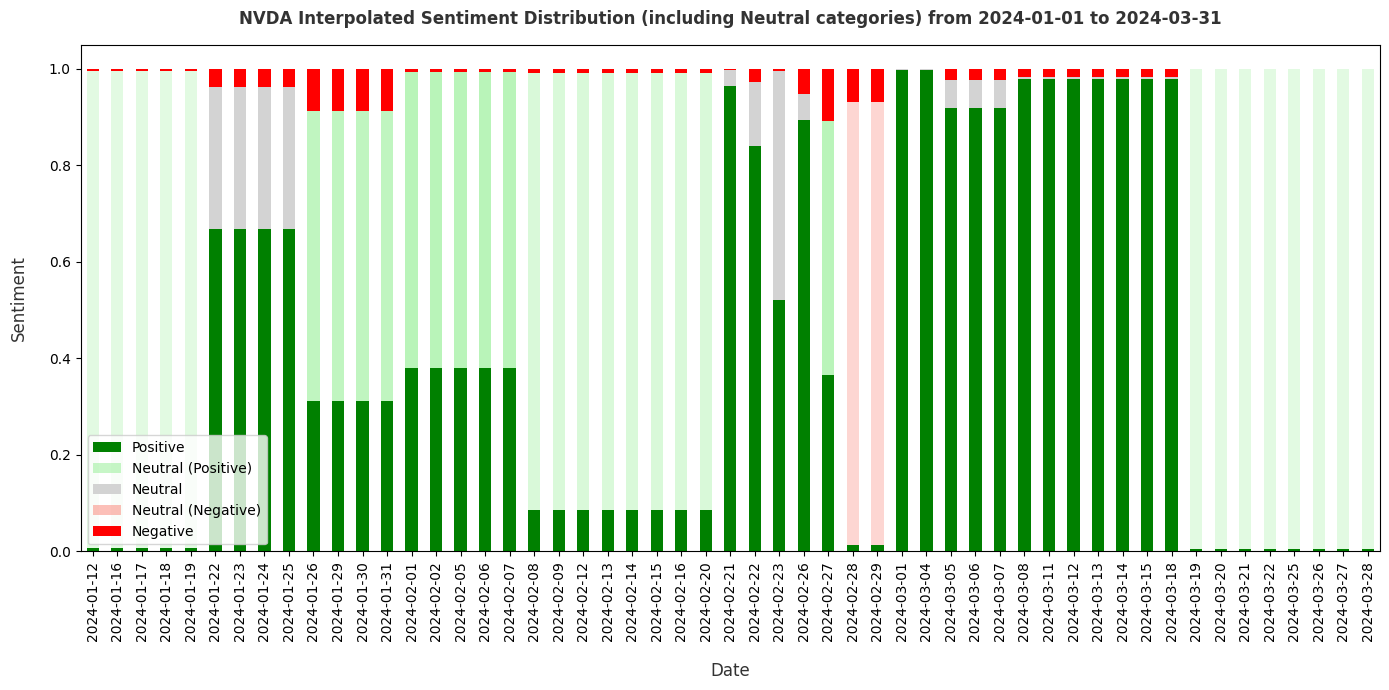

In [39]:
data = data.sort_index()

data.interpolate(method="pad", inplace=True)

# Creating 'lean_positive' and 'lean_negative' columns
data["lean_positive"] = data.apply(
    lambda row: row["positive"] if row["positive"] > row["negative"] else 0, axis=1
)
data["lean_negative"] = data.apply(
    lambda row: row["negative"] if row["negative"] > row["positive"] else 0, axis=1
)

# Ensure sentiment and price data are aligned on the same dates
data = data.dropna(
    subset=["positive", "negative", "lean_positive", "lean_negative", "Adj Close"]
)

positive_colors = ["green" for _ in range(len(data))]
neutral_colors = []
negative_colors = ["red" for _ in range(len(data))]

for i in range(len(data)):
    if data.iloc[i]["neutral"] >= data.iloc[i][["positive", "negative"]].max():
        if data.iloc[i]["negative"] > data.iloc[i]["positive"]:
            alpha = min(data.iloc[i]["negative"] + 0.25, 1)
            neutral_colors.append(
                (250 / 255, 128 / 255, 114 / 255, alpha)
            )  # Negative dominant neutral
        else:
            alpha = min(data.iloc[i]["positive"] + 0.25, 1)
            neutral_colors.append(
                (144 / 255, 238 / 255, 144 / 255, alpha)
            )  # Positive dominant neutral
    else:
        neutral_colors.append(
            (211 / 255, 211 / 255, 211 / 255, 1)
        )  # Light gray for neutral without dominance


fig, ax = plt.subplots(figsize=(14, 7))

# Plotting stacked bar chart for sentiment distribution
data["positive"].plot(
    kind="bar", stacked=True, color=positive_colors, label="Positive", ax=ax
)
bottom_positive = data["positive"]
data["neutral"].plot(
    kind="bar",
    stacked=True,
    color=neutral_colors,
    label="Neutral",
    ax=ax,
    bottom=bottom_positive,
)
bottom_neutral = bottom_positive + data["neutral"]
data["negative"].plot(
    kind="bar",
    stacked=True,
    color=negative_colors,
    label="Negative",
    ax=ax,
    bottom=bottom_neutral,
)

# Formatting x-axis to display dates without time
ax.xaxis.set_major_formatter(plt.FixedFormatter(data.index.strftime("%Y-%m-%d").values))
plt.xticks(rotation=90)

ax.set_title(
    f"{TICKER} Interpolated Sentiment Distribution (including Neutral categories) from {START} to {END}",
    pad=15,
    color="#333333",
    weight="bold",
)
ax.set_xlabel("Date", labelpad=15, color="#333333", fontsize="large")
ax.set_ylabel("Sentiment", labelpad=15, color="#333333", fontsize="large")

ax.legend(["Positive", "Neutral", "Negative"], loc="lower left")
plt.legend(
    [
        Patch(facecolor="green"),
        Patch(facecolor=(144 / 255, 238 / 255, 144 / 255, 0.5)),
        Patch(facecolor="lightgray"),
        Patch(facecolor=(250 / 255, 128 / 255, 114 / 255, 0.5)),
        Patch(facecolor="red"),
    ],
    ["Positive", "Neutral (Positive)", "Neutral", "Neutral (Negative)", "Negative"],
    loc="lower left",
)

plt.tight_layout()
plt.show()

## Correlation between sentiment and price

Correlation between positive sentiment and adjusted close price: 0.26
Correlation between negative sentiment and adjusted close price: 0.25
Correlation between lean positive sentiment and adjusted close price: 0.25
Correlation between lean negative sentiment and adjusted close price: -0.04
As positive sentiment increases, the adjusted close price tends to increase.
As negative sentiment increases, the adjusted close price tends to decrease.


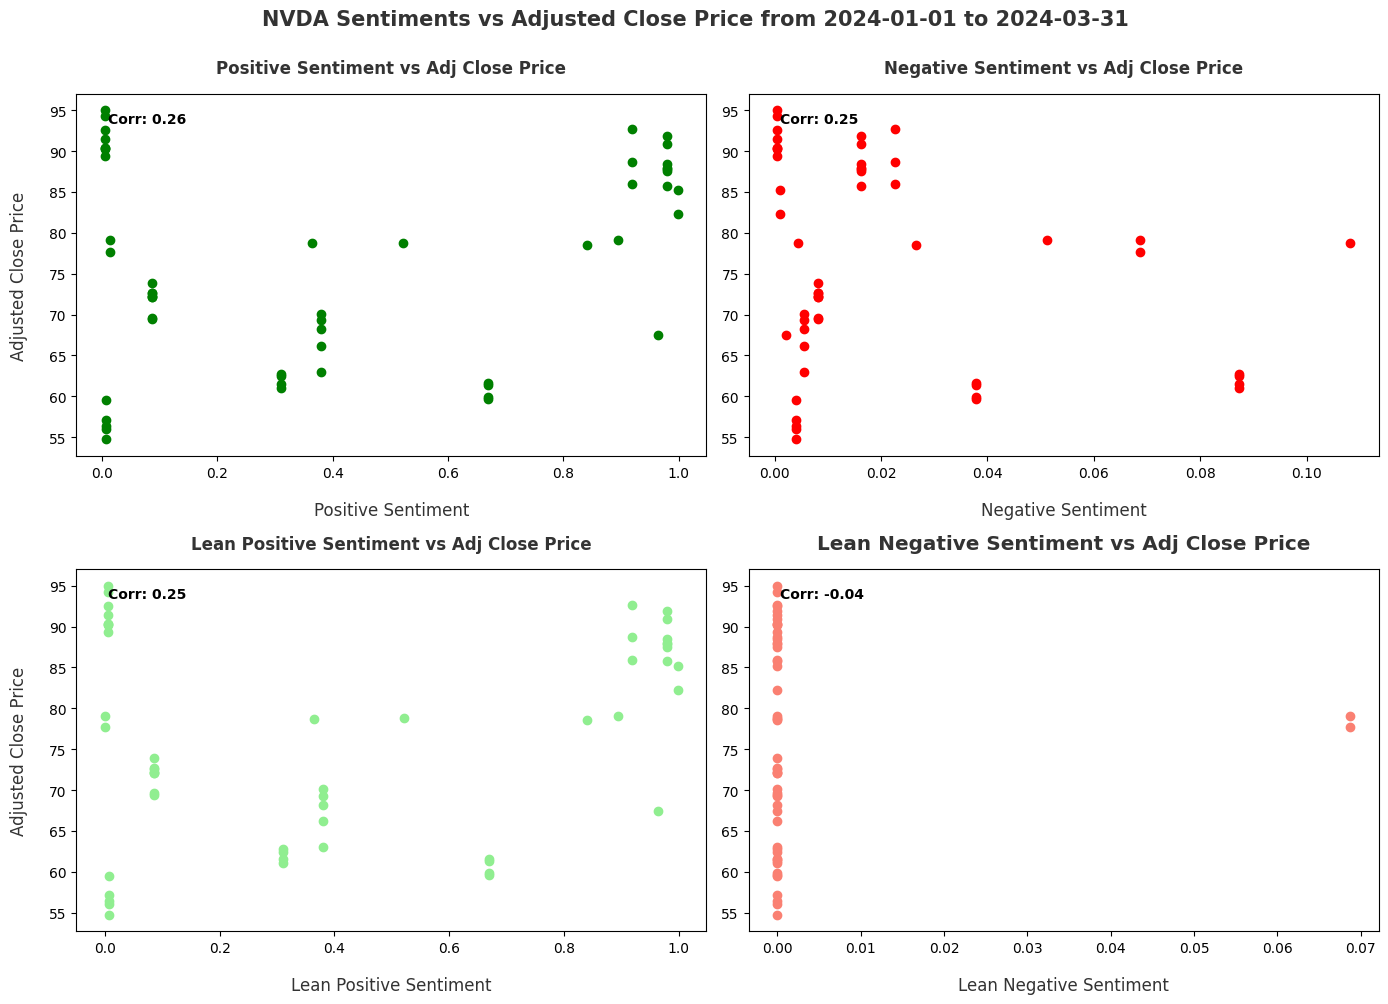

In [40]:
data = data.sort_index()

# Calculate correlation between sentiments and adjusted close price
correlation_positive = data["positive"].corr(data["Adj Close"])
correlation_negative = data["negative"].corr(data["Adj Close"])
correlation_lean_positive = data["lean_positive"].corr(data["Adj Close"])
correlation_lean_negative = data["lean_negative"].corr(data["Adj Close"])

correlation_negative = correlation_negative * -1
correlation_lean_negative = correlation_lean_negative * -1

print(
    f"Correlation between positive sentiment and adjusted close price: {correlation_positive:.2f}"
)
print(
    f"Correlation between negative sentiment and adjusted close price: {correlation_negative:.2f}"
)
print(
    f"Correlation between lean positive sentiment and adjusted close price: {correlation_lean_positive:.2f}"
)
print(
    f"Correlation between lean negative sentiment and adjusted close price: {correlation_lean_negative:.2f}"
)

if correlation_positive > 0:
    print(
        "As positive sentiment increases, the adjusted close price tends to increase."
    )
else:
    print(
        "As positive sentiment increases, the adjusted close price tends to decrease."
    )

if correlation_negative > 0:
    print(
        "As negative sentiment increases, the adjusted close price tends to decrease."
    )
else:
    print(
        "As negative sentiment increases, the adjusted close price tends to increase."
    )

# Create scatter plots for each sentiment type against the adjusted close price
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot for positive sentiment
axs[0, 0].scatter(data["positive"], data["Adj Close"], color="green")
axs[0, 0].set_title(
    "Positive Sentiment vs Adj Close Price", pad=15, color="#333333", weight="bold"
)
axs[0, 0].set_xlabel(
    "Positive Sentiment", labelpad=15, color="#333333", fontsize="large"
)
axs[0, 0].set_ylabel(
    "Adjusted Close Price", labelpad=15, color="#333333", fontsize="large"
)
axs[0, 0].text(
    0.05,
    0.95,
    f"Corr: {correlation_positive:.2f}",
    transform=axs[0, 0].transAxes,
    verticalalignment="top",
    weight="bold",
)

# Plot for negative sentiment
axs[0, 1].scatter(data["negative"], data["Adj Close"], color="red")
axs[0, 1].set_title(
    "Negative Sentiment vs Adj Close Price", pad=15, color="#333333", weight="bold"
)
axs[0, 1].set_xlabel(
    "Negative Sentiment", labelpad=15, color="#333333", fontsize="large"
)
axs[0, 1].text(
    0.05,
    0.95,
    f"Corr: {correlation_negative:.2f}",
    transform=axs[0, 1].transAxes,
    verticalalignment="top",
    weight="bold",
)

# Plot for lean positive sentiment
axs[1, 0].scatter(data["lean_positive"], data["Adj Close"], color="lightgreen")
axs[1, 0].set_title(
    "Lean Positive Sentiment vs Adj Close Price", pad=15, color="#333333", weight="bold"
)
axs[1, 0].set_xlabel(
    "Lean Positive Sentiment", labelpad=15, color="#333333", fontsize="large"
)
axs[1, 0].set_ylabel(
    "Adjusted Close Price", labelpad=15, color="#333333", fontsize="large"
)
axs[1, 0].text(
    0.05,
    0.95,
    f"Corr: {correlation_lean_positive:.2f}",
    transform=axs[1, 0].transAxes,
    verticalalignment="top",
    weight="bold",
)

# Plot for lean negative sentiment
axs[1, 1].scatter(data["lean_negative"], data["Adj Close"], color="salmon")
axs[1, 1].set_title(
    "Lean Negative Sentiment vs Adj Close Price",
    pad=15,
    color="#333333",
    fontsize="x-large",
    weight="bold",
)
axs[1, 1].set_xlabel(
    "Lean Negative Sentiment", labelpad=15, color="#333333", fontsize="large"
)
axs[1, 1].text(
    0.05,
    0.95,
    f"Corr: {correlation_lean_negative:.2f}",
    transform=axs[1, 1].transAxes,
    verticalalignment="top",
    weight="bold",
)

# Adjust the vertical position of the title to simulate padding
fig.suptitle(
    f"{TICKER} Sentiments vs Adjusted Close Price from {START} to {END}",
    y=1,
    fontsize=15,
    color="#333333",
    weight="bold",
)

plt.tight_layout()
plt.show()